In [1]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from nn import FunctionModel, save_model, load_model
import copy
import matplotlib.pyplot as plt
from triple_well_potential import TripleWellPotential

In [ ]:
ndim = 2
gamma = 10
kbt = .1
lam = 10
eta = 10
omega = gamma



# sample 
'''
Nx_sample = 1000
Nv_sample = 1000
'''
N_sample = 10**6
NA = 5000
NB = 5000

batch_size = 2048 #not implement

layers = [2*ndim,8,64,64,8,1]
activ  = 'sigmoid'

alpha_t = 1
T = 200
Nt = int(T/alpha_t)
Nsteps = 20
lr = 1e-3

device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")


def loss_fn(outputs,data,res_q,res_dq,res_dqx):
    gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                        grad_outputs=torch.ones_like(outputs),
                                        create_graph=True, retain_graph=True)[0]
    grad_x = gradients[:,:ndim]
    grad_v = gradients[:,ndim:]
    '''
    loss = (kbt*torch.sum(grad_v**2)+torch.sum(outputs**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)
    '''
    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    if res_q.shape != (res_q.shape[0],1):
        res_q=res_q.unsqueeze(1)

    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    loss = (omega*kbt*torch.sum(grad_v**2)+lam*torch.sum(outputs**2)+eta*torch.sum(grad_x**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)+torch.sum(grad_x*res_dqx)
            
    loss = loss / data.shape[0]

    return loss

def build_rightside(outputs,data,alpha_t,dU):
    with torch.no_grad():
        gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                            grad_outputs=torch.ones_like(outputs),
                                            create_graph=False, retain_graph=False)[0]
        grad_x = gradients[:,:ndim]
        grad_v = gradients[:,ndim:]

        '''
        res_q = -outputs-alpha_t*(data[:,ndim:]*grad_x-dU*grad_v)
        res_dq =-(1-gamma*alpha_t)*grad_v*kbt
        '''
        # print(outputs.shape,torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True).shape)
        #print(torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True).shape)
        res_q = -lam*outputs-torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True)
        res_dq = (gamma-omega)*grad_v
        res_dqx = -eta*grad_x

    return res_q, res_dq, res_dqx

def pinn_loss(outputs,data,dU,create_graph=False):

    grad = torch.autograd.grad(outputs=outputs, inputs=data, grad_outputs=torch.ones_like(outputs), create_graph=True)[0] 
    grad_x = grad[:,:ndim]
    grad_v = grad[:,ndim:] 
    x = data[:,:ndim]
    v = data[:,ndim:]

    # \Delta q_v
    lap_v = torch.zeros(size=(outputs.shape[0],),dtype=torch.float32,device = grad.device)
    for i in range(ndim):
        temp = torch.autograd.grad(outputs=grad[:,ndim+i], inputs=data, grad_outputs=torch.ones_like(grad[:,0]), create_graph=create_graph,retain_graph=True)[0]
        #print(temp[:,ndim+i].shape,lap_v.shape)
        lap_v += temp[:,ndim+i]
    lap_v.unsqueeze_(dim=1)


    return torch.sum((data[:,ndim:]*grad_x-(dU+gamma*v)*grad_v),dim=1,keepdim=True)+kbt*gamma*lap_v


x1 = (torch.rand(size=(N_sample,1),dtype=torch.float32))*4-2
x2 = (torch.rand(size=(N_sample,1),dtype=torch.float32))*3-1
x = torch.cat((x1,x2),dim=1)
potential = TripleWellPotential()


v = torch.randn(size=(N_sample,ndim),dtype = torch.float32)*np.sqrt(kbt)
data = torch.cat((x,v),dim=1)
dU = potential.gradient(data[:,:ndim])


r=0.2
vA = torch.randn(size=(NA,ndim),dtype = torch.float32)*np.sqrt(kbt)
xA = torch.from_numpy(potential.points_in_a(NA,r).astype(np.float32))
xA = torch.cat((xA,vA),dim=1)
vB = torch.randn(size=(NB,ndim),dtype = torch.float32)*np.sqrt(kbt)
xB = torch.from_numpy(potential.points_in_b(NB,r).astype(np.float32))
xB = torch.cat((xB,vB),dim=1)
labelA = 0*torch.ones_like(xA[:,0])
labelB = 1*torch.ones_like(xB[:,0])

data_b = torch.cat((xA,xB),dim=0)
label_b = torch.cat((labelA,labelB),dim=0).unsqueeze(dim=1)
print(label_b.shape)
del xA,xB,labelA,labelB

b_lossfn = torch.nn.MSELoss()
b_lossfn(data[:,0],torch.ones_like(data[:,0]))



# q = FunctionModel(layer_sizes=layers,activation=activ)
model_file = f'./model/gamma10_kbt0.5_1I.pth'
config_file = f'./config/gamma10_kbt0.5_1I.txt'
q = load_model(model_file,config_file)


    

torch.Size([10000, 1])
Configuration loaded from ./config/gamma10_kbt0.5_1I.txt
Model loaded from ./model/gamma10_kbt0.5_1I.pth


In [116]:
def split(dataset,batchsize,shuffle=True):
    length = len(dataset[0])
    if shuffle:
        per = torch.randperm(length)
        for d in dataset:
            d = d[per]
    
    batches = []
    N = int(np.ceil(length/batchsize))
    for i in range(N): 
        batches.append((d[i*batchsize:min((i+1)*batchsize,length)] for d in dataset)) 
    return iter(batches)

In [117]:
def train_step(model,dataset,batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,alpha_l2=0,check_point = 10):
    loss_list,b_loss_list,tot_loss_list,pinn_loss_list = [],[],[],[]
    for i in range(num_epoches):
        
        dataloader = split(dataset,batchsize,shuffle=True)
        for d,res_q,res_dq,res_dqx,dU in dataloader:
            
            #torch.cuda.empty_cache()  
            #d=d.to(device)
            #rq=rq.to(device)
            #rdq=rdq.to(device)
            opt.zero_grad()
            y = model(d)
            y_b = model(data_b)
            
            loss = loss_fn(y,d,res_q,res_dq,res_dqx)
            b_loss = b_lossfn(y_b,label_b)
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param) ** 2
            tot_loss = loss + b_loss*alpha_b+l2_reg*alpha_l2
            tot_loss.backward()
            opt.step()
            
        
        if i%check_point == 0:
            # print(i)
            #print(f"{i+1} epoches completed!")
            loss_list.append(loss.item())
            b_loss_list.append(b_loss.item())
            tot_loss_list.append(tot_loss.item())
            
            pinn_loss_list.append(torch.mean(pinn_loss(model(d),d,dU)**2).item())
            

    return loss_list,b_loss_list, tot_loss_list,pinn_loss_list

def train(model,data:torch.Tensor,batchsize,data_b,label_b,dU,alpha_b,lr,num_tsteps,num_epoches,device,checkpoint=10):
    torch.cuda.empty_cache()
    data = data.to(device)
    dU=dU.to(device)
    label_b = label_b.to(device)
    data_b = data_b.to(device)


    
    data.requires_grad_(True)
    loss_list,b_loss_list,tot_loss_list,pinn_loss_list = [],[],[],[]
    for t in range(num_tsteps):
        print(f"itr{t}: Building dataset!")
        y = model(data)
        res_q,res_dq,res_dqx=build_rightside(y,data,alpha_t,dU)
        #dataset = TensorDataset(data.to('cpu'),res_q.to('cpu'),res_dq.to('cpu'))
        opt = optim.Adam(model.parameters(),lr=lr)
        # dataloader = (data,res_q,res_dq)
        print(f"itr{t}: Training!")
        ll,bl,tl,pl=train_step(model,[data,res_q,res_dq,res_dqx,dU],batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,check_point=checkpoint)
        loss_list += ll
        b_loss_list += bl
        tot_loss_list += tl
        pinn_loss_list += pl

        # torch.cuda.empty_cache()
        print(f"itr{t}: Training completed!")
       
        
        
    
    return loss_list,b_loss_list,tot_loss_list,pinn_loss_list

In [ ]:
## initialize
data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**19
#eta = 10
#lr = 1e-3
# kbt = 1
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = 1e-5,
                                          num_tsteps=100,
                                          num_epoches=Nsteps,
                                          device=device,
                                          dU=dU,
                                          checkpoint=10)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

In [164]:

data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**19
#eta = 10
lr = 1e-4
#eta = 1
#lam = 1
#kbt = .5
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt*2,
                                          num_epoches=Nsteps,
                                          device=device,
                                          dU=dU,
                                          checkpoint=10)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

In [103]:
print(lam,eta,omega)

1 1 10


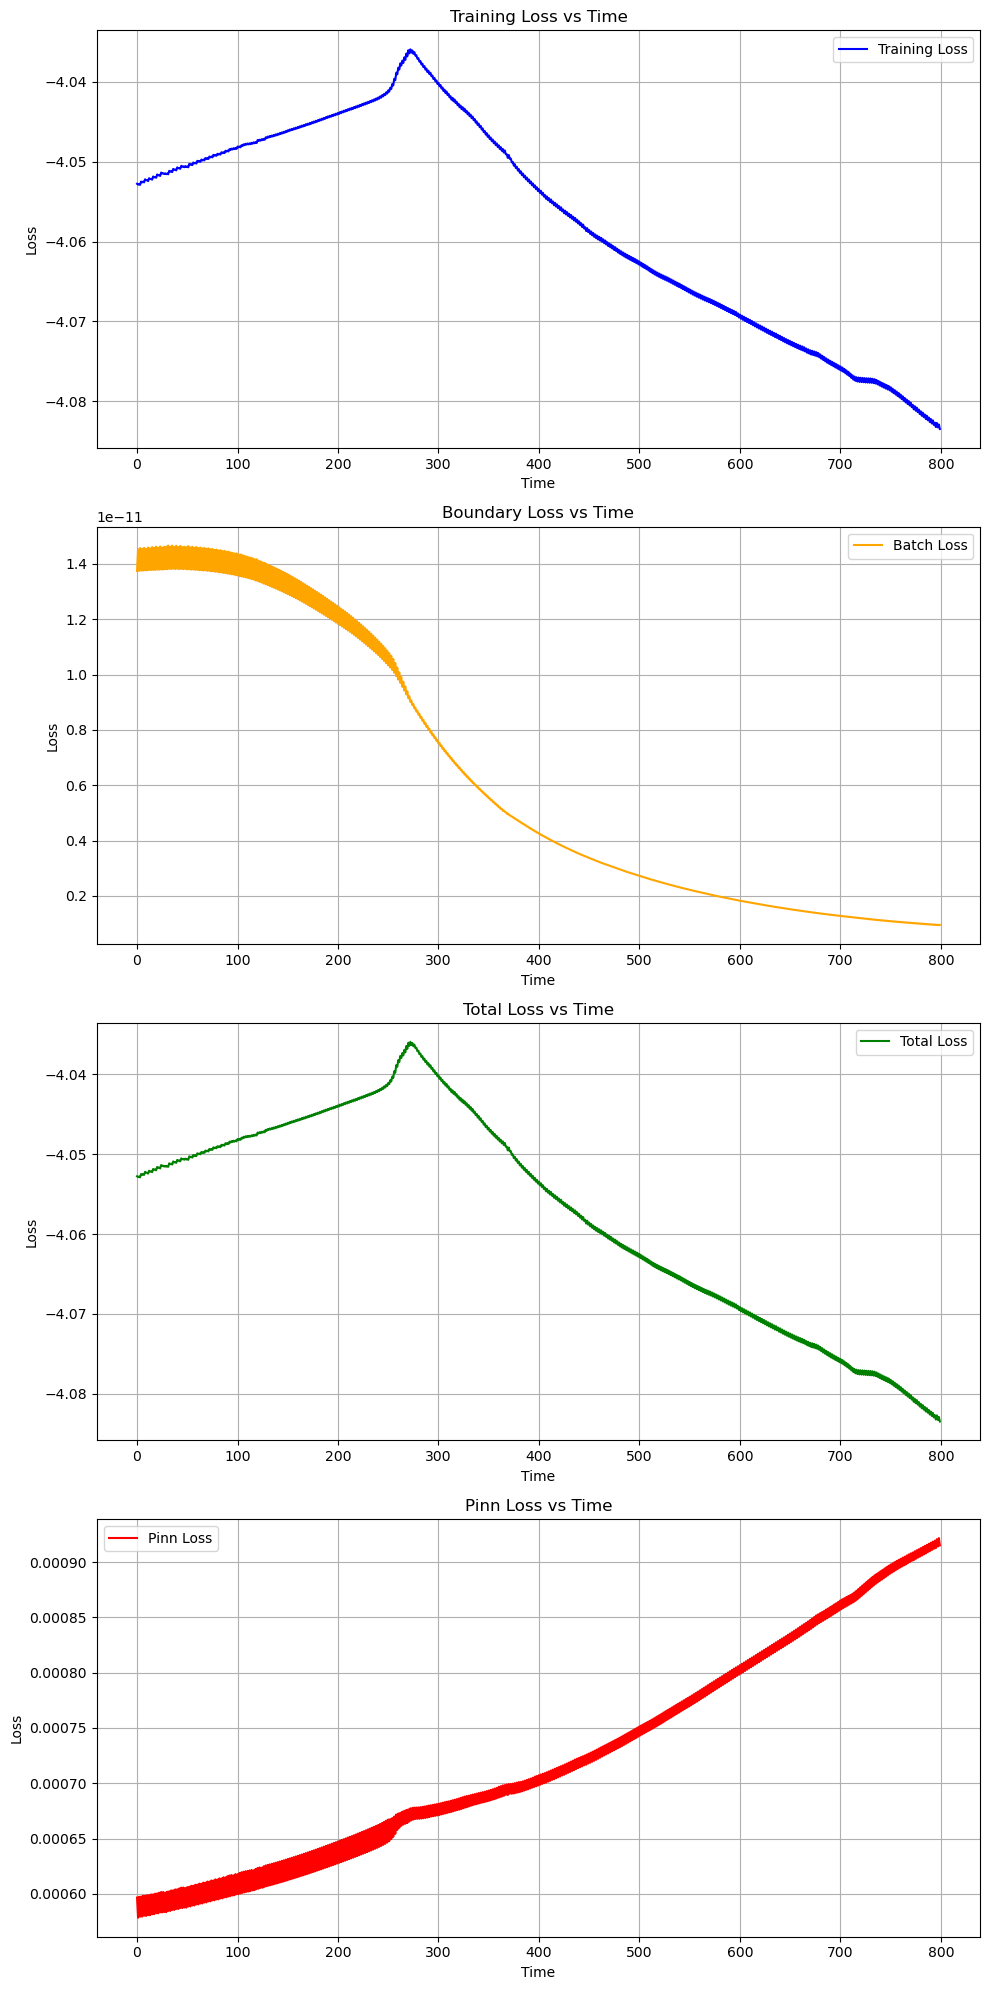

In [161]:
 # Length of the data  
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [162]:
xmin, xmax = -2, 2
ymin, ymax = -1, 2
dx = 0.01
dy = 0.01
Nx = int((xmax - xmin) / dx)
Ny = int((ymax - ymin) / dy)


Ncol = Nx + 1
Nrow = Ny + 1
x = np.linspace(xmin, xmax, Nx + 1)
y = np.linspace(ymin, ymax, Ny + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Ny - 1:
    ycal = y[1:-1]
else:
    ycal = y


X, Y = np.meshgrid(xcal, ycal)
# print(X.shape, V)

points = np.array([X.reshape(-1), Y.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

ddd = torch.zeros(size=(points.shape[0],2*ndim)).to(device)

ddd[:,:ndim] = torch.from_numpy(points).to(device)
ddd[:,ndim:] = 0
qqq = torch.zeros(size=(ddd.shape[0],1),dtype=torch.float32,device=device)
NNN = 10000
with torch.no_grad():
    for ttt in range(NNN):
        ddd[:,ndim:] = torch.randn(size=(1,ndim),device=device)*torch.ones(size=(ddd.shape[0],ndim),device=device)*np.sqrt(kbt)*0
        #print(ddd.shape)
        temp = q(ddd)
        #print(ddd.shape,temp.shape)
        qqq += temp

qqq = qqq/NNN
qqq = qqq.squeeze().to('cpu').detach()


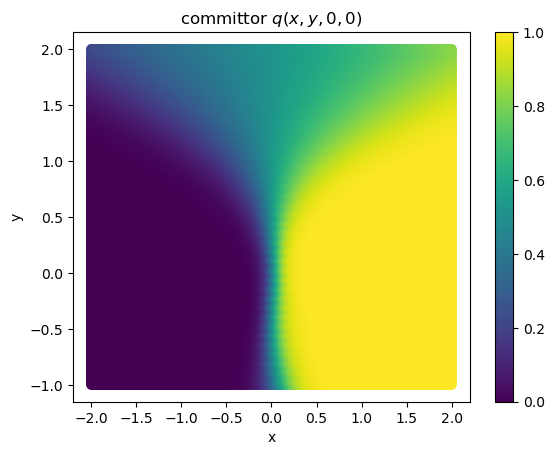

In [163]:
plt.scatter(points[:, 0], points[:, 1], c=qqq)
plt.title('committor $q(x,y,0,0)$')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

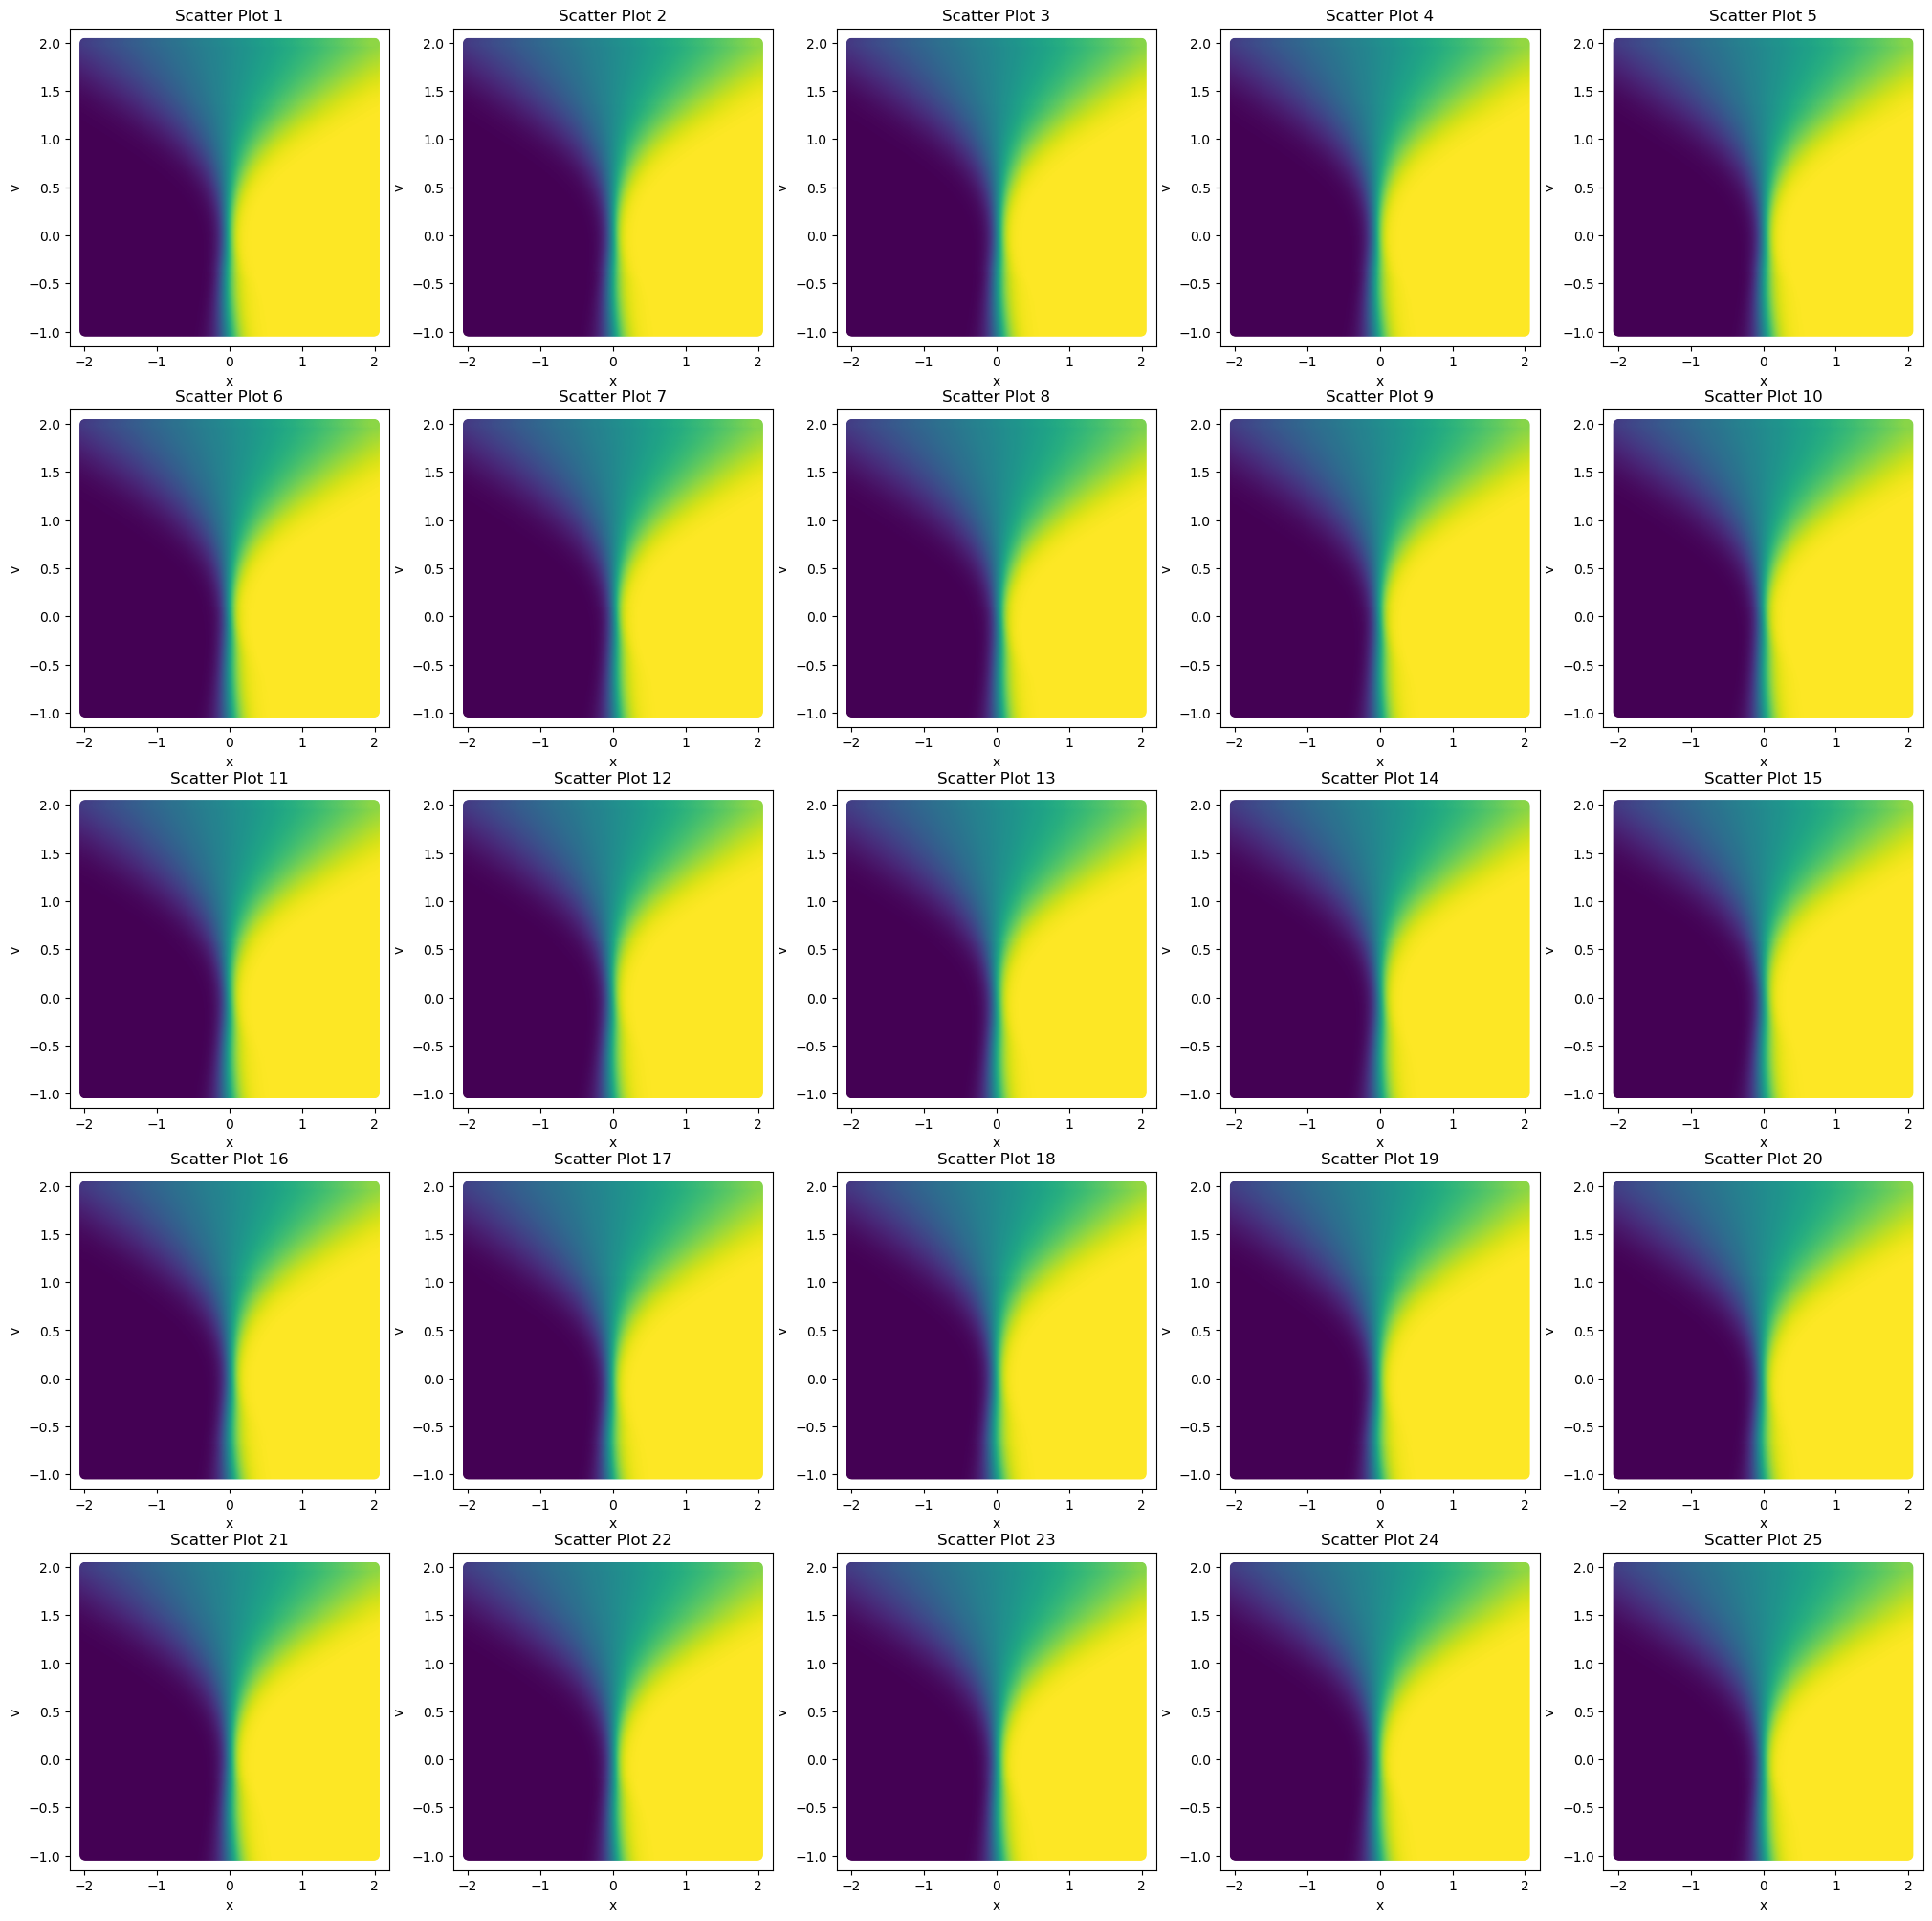

In [137]:
mm=5
nn=5
fig, axs = plt.subplots(mm, nn, figsize=(mm*5, nn*5))  

# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        vvm1 = torch.randn(size=(1,ndim),dtype = torch.float32).to(device)*np.sqrt(kbt)
        ddd[:,(ndim):] = vvm1
        qqq = q(ddd).squeeze().to('cpu').detach() 
        
        # Create scatter plot  
        axs[i, j].scatter(points[:,0],points[:,1],c=qqq)  
        axs[i, j].set_title(f'Scatter Plot {i*nn + j + 1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')

In [2]:
simulation = np.loadtxt('./model/simulation_kbt0.5_gamma0.1_0.txt')
q0 = np.loadtxt('./model/fd_kbt.1.txt')
#q_simulation = np.loadtxt('./model/q_s_1d.txt')
print(simulation.shape)


(4941, 3)


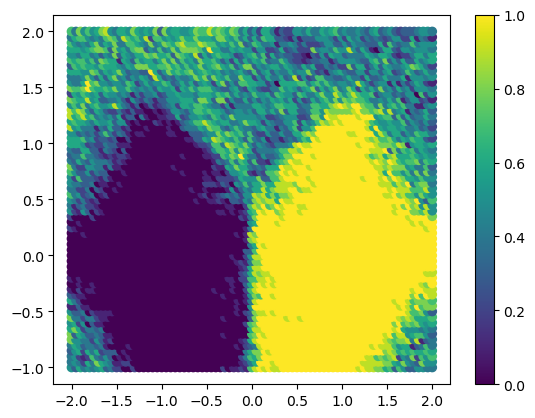

In [3]:

plt.scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])
plt.colorbar()
plt.show()


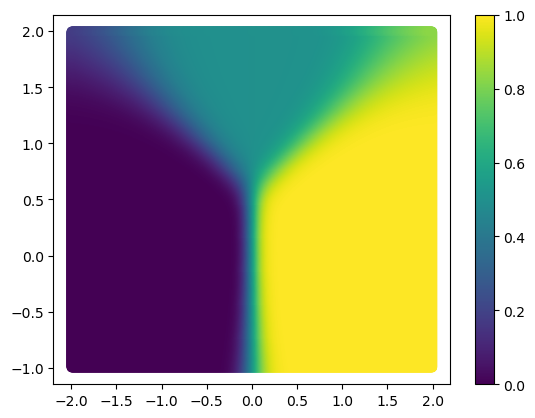

In [140]:
plt.scatter(q0[:,0],q0[:,1],c=q0[:,2])
plt.colorbar()
plt.show()

In [141]:
ddd = torch.zeros(size=(q0.shape[0],2*ndim),dtype=torch.float32)
ddd[:,:ndim] = torch.from_numpy(q0[:,:ndim])
label = torch.from_numpy(q0[:,ndim].astype(np.float32))

activ = 'sigmoid'
qq = FunctionModel(layer_sizes=layers,activation=activ)
qq.to(device)
ddd=ddd.to(device)
label = label.to(device).unsqueeze(dim=1)
lossfunction = torch.nn.MSELoss()
opt = optim.Adam(qq.parameters(),lr = 1e-3)
num_epoches = 2000
for _ in range(num_epoches):
    opt.zero_grad()
    loss = lossfunction(qq(ddd),label)
    loss.backward()
    opt.step()


In [142]:
xmin, xmax = -2, 2
ymin, ymax = -1, 2
dx = 0.01
dy = 0.01
Nx = int((xmax - xmin) / dx)
Ny = int((ymax - ymin) / dy)


Ncol = Nx + 1
Nrow = Ny + 1
x = np.linspace(xmin, xmax, Nx + 1)
y = np.linspace(ymin, ymax, Ny + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Ny - 1:
    ycal = y[1:-1]
else:
    ycal = y


X, Y = np.meshgrid(xcal, ycal)
# print(X.shape, V)

points = np.array([X.reshape(-1), Y.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

ddd = torch.zeros(size=(points.shape[0],2*ndim)).to(device)

ddd[:,:ndim] = torch.from_numpy(points).to(device)
ddd[:,ndim:] = 0
qqqq = qq(ddd).squeeze().to('cpu').detach()


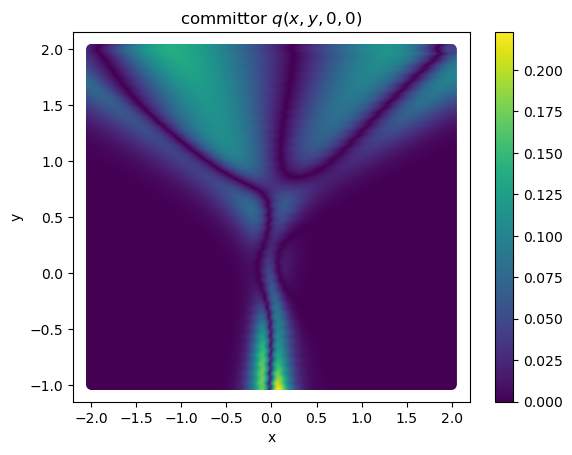

In [150]:
ttt = np.abs(qqqq-qqq)
#ttt[ttt>0.1] = 0.1
plt.scatter(points[:, 0], points[:, 1], c=ttt)
plt.title('committor $q(x,y,0,0)$')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [158]:
TWP = TripleWellPotential()
U = TWP.potential(points)
p = np.exp(-(U-min(U))/kbt)
p = p/np.sum(p)
print(f'Absolute error: {np.sum(p*ttt.numpy()**2)**0.5}')
print(f'Reletive error: {np.sum(p*ttt.numpy()**2)**0.5/np.sum(p*qqqq.numpy()**2)**0.5}')

Absolute error: 7.964668044483712e-06
Reletive error: 1.126375231026487e-05


In [144]:
'''
plt.scatter(points[:, 0], points[:, 1], c=qqq)
plt.title('committor $q(x,v)$')
plt.xlabel('x')
plt.ylabel('v')
plt.colorbar()
plt.show()
'''

"\nplt.scatter(points[:, 0], points[:, 1], c=qqq)\nplt.title('committor $q(x,v)$')\nplt.xlabel('x')\nplt.ylabel('v')\nplt.colorbar()\nplt.show()\n"

In [145]:
'''
vslice = 0.0
Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r')
plt.plot(xcal[:], q0,'g')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.title(f'slice with v={vslice}')
plt.show()
'''

"\nvslice = 0.0\nQ = qqq.reshape(X.shape)\nQfd = fd[:,2].reshape(X.shape)\n#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])\nplt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])\nplt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r')\nplt.plot(xcal[:], q0,'g')\nplt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b')\n#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])\nplt.xlabel('x')\nplt.ylabel('q')\nplt.title(f'slice with v={vslice}')\nplt.show()\n"

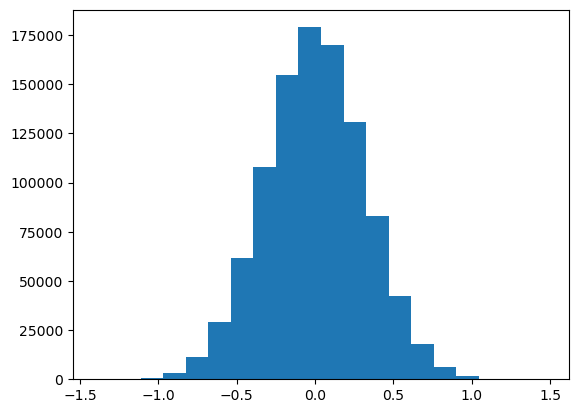

In [146]:
plt.hist(data.to('cpu').detach().numpy()[:,3],bins=20)
plt.show()

In [147]:
model_file = f'./model/gamma{gamma}_kbt{kbt}_{lam}I.pth'
config_file = f'./config/gamma{gamma}_kbt{kbt}_{lam}I.txt'
save_model(q,model_file,config_file)

Model saved to ./config/gamma10_kbt0.1_10I.txt
Model saved to ./model/gamma10_kbt0.1_10I.pth
